In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LinearSegmentedColormap

EXAMPL_TOKENS = ['I', 'went', 'to', 'school', '.']
CUSTOM_CMAP = LinearSegmentedColormap.from_list('', ['gainsboro', 'red'])


In [107]:

def get_random_graph(num_tokens, num_layers):
    G = nx.Graph()

    layer_pos_fac = 2.5
    token_pos_fac = 2.5
    module_pos_fac = 1

    # Add nodes
    for token_pos in range(num_tokens):
        G.add_node(f'emb.{token_pos}', pos=(token_pos * token_pos_fac, 0), type='emb')
        for layer_id in range(1, num_layers + 1):
            for i, module in enumerate(['attn', 'mlp']):
                curr_node = f"{layer_id}.{module}.{token_pos}"
                curr_pos = (token_pos * token_pos_fac,layer_id * layer_pos_fac + i * module_pos_fac)
                G.add_node(curr_node, pos=curr_pos, type=module)

    G.add_node(f'target', pos=((token_pos + 1) * token_pos_fac, ((layer_id + 1) * layer_pos_fac)), type='target')

    # add edges
    node_queue = [list(G.nodes(data=True))[-1]]

    while node_queue:
        curr_node, curr_data = node_queue.pop(0)
        curr_pos = curr_data['pos']

        if curr_node == 'target':
            valid_nodes = [(node, data) for node, data in G.nodes(data=True) if data['pos'][0] == (curr_pos[0] - token_pos_fac) and data['pos'][1] < curr_pos[1]]
            num_edges = 10
        else:
            valid_nodes = [(node, data) for node, data in G.nodes(data=True) if data['pos'][0] <= curr_pos[0] and data['pos'][1] < curr_pos[1]]
            num_edges = int(random.random() * (curr_pos[0] / token_pos_fac + curr_pos[0] / layer_pos_fac ))
        edge_nodes = random.sample(valid_nodes, k=min([num_edges, len(valid_nodes)]))
        for node, data in edge_nodes:
            G.add_edge(curr_node, node, weight=round(random.random(), 2), is_same_token = data['pos'][0] == curr_pos[0])
        node_queue.extend(edge_nodes)

    return G

In [141]:
from dataclasses import dataclass

@dataclass
class ContributionTracePlotConfig:

    # label spaces
    x_label_space = 2
    y_label_space = 3

    # node shapes
    emb_node_shape='o'
    attn_node_shape='s'
    mlp_node_shape='d'
    target_node_shape='^'

    # node colors
    emb_node_color='gold'
    attn_node_color='skyblue'
    mlp_node_color='orange'
    target_node_color='red'

    # node sizes
    node_size=150,
    target_node_size=200

    # edge conf
    edge_width = 0.5
    show_edge_arrows = True
    edge_arrow_style = '<-'
    edge_cmap = CUSTOM_CMAP
    


In [145]:
def plot_contribution_trace(graph, tokens, num_layers, num_tokens, **kwargs):
    
    # adjust positions
    conf = ContributionTracePlotConfig(**kwargs)

    pos = nx.get_node_attributes(graph, 'pos')
    plot_adjusted_pos = {node_key: (x_pos + conf.y_label_space, y_pos + conf.x_label_space) for node_key, (x_pos, y_pos) in pos.items()}

    # create node groups:
    node_groups = []
    emb_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'emb']
    node_groups.append({"nodelist": emb_nodes, "node_shape": conf.emb_node_shape, 'node_color': conf.emb_node_color, 'node_size': conf.node_size })

    attn_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'attn']
    node_groups.append({"nodelist": attn_nodes, "node_shape": conf.attn_node_shape, 'node_color': conf.attn_node_color, 'node_size': conf.node_size })

    mlp_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'mlp']
    node_groups.append({"nodelist": mlp_nodes, "node_shape": conf.mlp_node_shape, 'node_color': conf.mlp_node_color, 'node_size': conf.node_size })

    target_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'target']
    node_groups.append({"nodelist": target_nodes, "node_shape": conf.target_node_shape, 'node_color': conf.target_node_color, 'node_size': conf.target_node_size })

    # create edge groups
    edge_groups = []
    dif_tok_edges = [((_from, _to), data['weight']) for _from, _to, data in graph.edges(data=True) if not data['is_same_token']]
    if dif_tok_edges:
        edges, weights = zip(*dif_tok_edges)
        edge_groups.append({"edgelist": edges, "edge_color": weights, "connectionstyle": 'arc,angleA=0,angleB=180,armA=30,armB=30,rad=30'})

    same_tok_edges = [((_from, _to), data['weight']) for _from, _to, data in graph.edges(data=True) if data['is_same_token']]
    if same_tok_edges:
        edges, weights = zip(*same_tok_edges)
        edge_groups.append({"edgelist": edges, "edge_color": weights, "connectionstyle": 'arc3,rad=0.3'})

    # initiate figure 
    x_pos, y_pos = graph.nodes['target']['pos']
    width = (num_tokens + 1) + conf.y_label_space / (x_pos / (num_tokens + 1))
    height = (num_layers + 1) + conf.x_label_space / (y_pos / (num_layers + 1))
    plt.figure(figsize=(width, height))

    # draw nodes
    for node_group in node_groups:
        nx.draw_networkx_nodes(graph, plot_adjusted_pos, **node_group)

    # draw edges
    for edge_group in edge_groups:
        nx.draw_networkx_edges(graph, plot_adjusted_pos, 
                            arrowstyle=conf.edge_arrow_style,
                            width=conf.edge_width, 
                            edge_vmin = 0,
                            edge_cmap=conf.edge_cmap,
                            arrows=conf.show_edge_arrows,
                            **edge_group) 

    # add target Label
    x_pos, y_pos = graph.nodes['target']['pos']
    plt.text(x_pos + conf.y_label_space, y_pos + conf.x_label_space -1, 'Target', ha='center')

    # X labels
    layer_pos = [(layer, graph.nodes[f"{layer}.attn.0"]['pos'][1]) for layer in range(1, num_layers + 1)]
    plt.text(0, conf.x_label_space, 'Emb.', va='center')
    for i, pos in layer_pos:
        plt.text(0, conf.x_label_space + pos, f"Layer {i}")

    token_pos = [graph.nodes[f"1.attn.{token}"]['pos'][0] for token in range(num_tokens)]
    for pos, token in zip(token_pos, tokens):
        plt.text(conf.y_label_space + pos, 0, token, ha='center')

    plt.axis('off')
    plt.show()

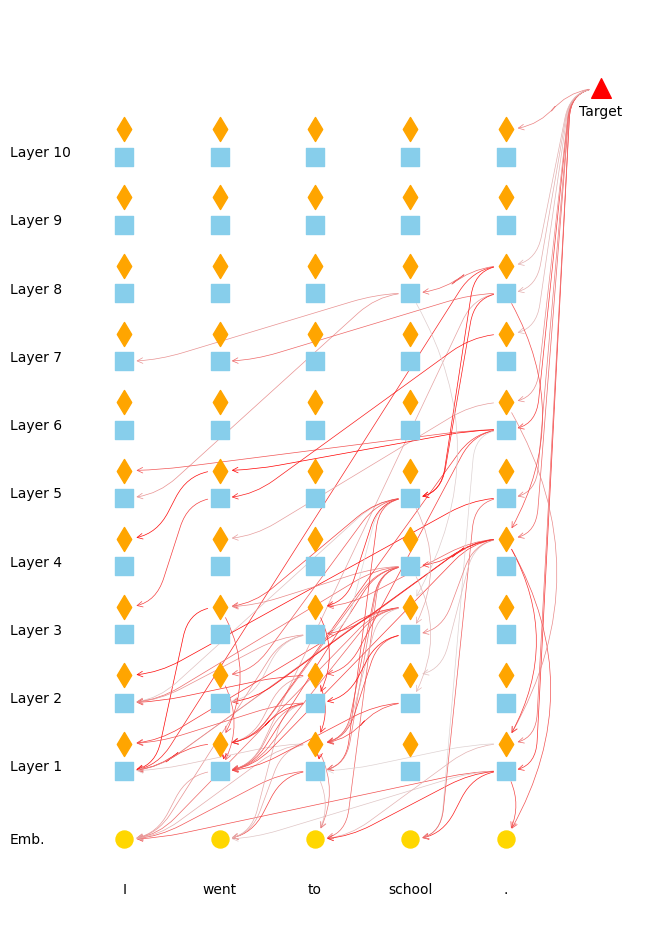

In [146]:
num_tokens = 5
num_layers = 10
tokens = EXAMPL_TOKENS
G = get_random_graph(num_tokens, num_layers)

plot_contribution_trace(G, tokens, num_layers, num_tokens)

In [93]:
edges, weights = zip(*[((_from, _to), data['weight']) for _from, _to, data in G.edges(data=True) if not data['is_same_token']])


ValueError: not enough values to unpack (expected 2, got 0)

In [94]:
[((_from, _to), data['weight']) for _from, _to, data in G.edges(data=True) if not data['is_same_token']]

[]

In [95]:
G.edges()

EdgeView([])